+ **목적** : 리뷰글의 긍정/부정 예측을 위한 모델 생성

In [1]:
# Colab에 Mecab 설치
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

In [ ]:
# PyKoSpacing 설치
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
# from konlpy.tag import Mecab
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# wordcloud 준비
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)          


### 1.자료 불러오기 : 티몬 리뷰

In [4]:
##########
# 자료 불러오기
#####

from os import listdir

# 경로 설정
directory_name = "./review_naver"

# 파일명 가져오기
file_names = listdir(directory_name)[1:]

tmon_data = pd.DataFrame()

# 전체 자료 불러오기 & 병합
for open_file in file_names:
    df_temp = pd.read_excel(directory_name +'/'+ open_file,'Report')
    tmon_data = pd.concat([tmon_data, df_temp], ignore_index=True)

In [5]:
tmon_data.head()

,주문일시,매장명,별점,리뷰,답글,리뷰 링크,메뉴명,수량,주문금액,테마,매장유입,검색유입
0,2020.05.02,폴바셋 신세계 강남점,5.0,늘 맛있슴.......,NaN,http://booking.naver.com/review/bizes/344496/1...,아이스 카페라떼,1,9600,NaN,N,Y
1,2020.05.02,폴바셋 신세계 강남점,5.0,늘 맛있슴.......,NaN,http://booking.naver.com/review/bizes/344496/1...,아메리카노,1,9600,NaN,N,Y
2,2020.05.03,폴바셋 신세계 강남점,5.0,줄안서도 간편하게 주문할수있어서 좋아요!,NaN,http://booking.naver.com/review/bizes/344496/1...,아이스 시나몬라떼,1,5800,NaN,N,Y
3,2020.05.17,폴바셋 신세계 강남점,5.0,아라는 괜찮은 듯,NaN,http://booking.naver.com/review/bizes/344496/1...,아이스 카페라떼,1,5300,NaN,Y,N
4,2020.05.19,폴바셋 신세계 강남점,5.0,맛있어요 :),NaN,http://booking.naver.com/review/bizes/344496/1...,아이스 카페라떼,1,5300,NaN,Y,N


In [6]:
tmon_data = tmon_data[['별점', '리뷰']]
tmon_data.rename(columns = {'리뷰' : 'reviews', '별점' : 'ratings'}, inplace = True)


In [7]:
tmon_data.tail()

,ratings,reviews
55948,4.0,맛있어요~~
55949,4.0,맛있어요~~
55950,5.0,폴바셋 아이스크림류는 다 엄지척!!
55951,5.0,폴바셋 아이스크림류는 다 엄지척!!
55952,5.0,폴바셋 아이스크림류는 다 엄지척!!


In [62]:
# total_data2['reviews'] = total_data2['reviews'].replace("\n", " ")

In [8]:
tmon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55953 entries, 0 to 55952
Data columns (total 2 columns):
ratings    55953 non-null float64
reviews    55953 non-null object
dtypes: float64(1), object(1)
memory usage: 874.3+ KB


<function matplotlib.pyplot.show(*args, **kw)>

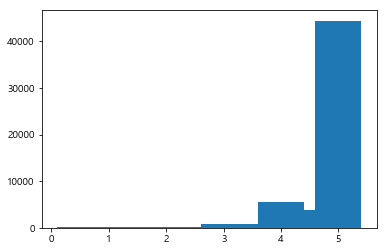

In [10]:
plt.bar(tmon_data.groupby(['ratings']).count().index, tmon_data.groupby(['ratings']).count()['reviews'])
plt.show

### 2.데이터 전처리/Set 분류

In [11]:
# 긍종/부정으로 나누기
tmon_data['label'] = np.select([tmon_data.ratings > 3], [1], default=0)

# 중복 제거
tmon_data['ratings'].nunique(), tmon_data['reviews'].nunique(), tmon_data['label'].nunique()
tmon_data.drop_duplicates(subset=['reviews'], inplace=True) 

# 공백값 제거
tmon_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
tmon_data = tmon_data.dropna(how='any') # Null 값 제거

# index 초기화
tmon_data = tmon_data.reset_index(drop=True)


In [12]:
print('총 샘플의 수 :',len(tmon_data))

총 샘플의 수 : 34574


In [13]:
from konlpy.tag import Okt
okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")
okt = Okt()

C:\Users\khpark\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [14]:
def tokenize(doc):
    #형태소와 품사를 join
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

In [15]:
# train_data['label'].value_counts().plot(kind = 'bar')
# plt.show()

In [16]:
# train/test Set 분류
train_data, test_data = train_test_split(tmon_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 25930
테스트용 리뷰의 개수 : 8644


In [17]:
test_data.values

array([[5.0, '최애\n음료', 1],
       [4.0, '부드럽고 맛있었어요~^^', 1],
       [5.0, '좋아요 맛나요', 1],
       ...,
       [5.0, '역시 맛나요', 1],
       [5.0, '커피는 항상 맛있고\n쾌적하고 좋아유 ', 1],
       [4.0,
        '아이스크림이 맛있었어요!\n라떼는 부드러운데 진하고 섞여서 뭔가 다크 초콜릿 같은 맛이었습니다:)\n가격은 좀 비싸긴 하더라구요🤣',
        1]], dtype=object)

In [19]:
# %%time
train_docs = [(tokenize(row[1]), row[2]) for row in train_data.values]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data.values]

In [20]:
print(train_docs[0])
print(test_docs[0])

(['맛있다/Adjective', 'ㅎㅎㅎ/KoreanParticle'], 1)
(['최애/Noun', '\n/Foreign', '음료/Noun'], 1)


In [22]:
tokens = [t for d in train_docs for t in d[0]]
print("토큰개수:", len(tokens))

토큰개수: 201114


In [23]:
import nltk
text = nltk.Text(tokens, name='NMSC')

#토큰개수
print(len(text.tokens))

#중복을 제외한 토큰개수
print(len(set(text.tokens)))

#출력빈도가 높은 상위 토큰 10개
print(text.vocab().most_common(10))

201114
7557
[('맛있다/Adjective', 10628), ('좋다/Adjective', 6388), ('맛/Noun', 4581), ('./Punctuation', 4214), ('하다/Verb', 4092), ('라떼/Noun', 3688), ('도/Josa', 3455), ('주문/Noun', 3428), ('\n/Foreign', 3101), ('이/Josa', 2979)]


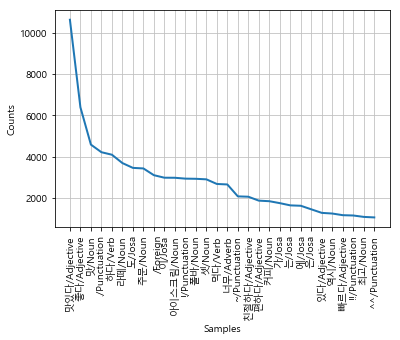

In [24]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# plt.figure(figsize=(20,10))
text.plot(30)

In [25]:
FREQUENCY_COUNT = 1000
selected_words = [f[0] for f in text.vocab().most_common(FREQUENCY_COUNT)]

In [26]:
#단어리스트 문서에서 상위 10000개들중 포함되는 단어들이 개수
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

In [27]:
#문서에 들어가는 단어 개수
x_train = [term_frequency(d) for d,_ in train_docs]
x_test = [term_frequency(d) for d,_ in test_docs]

In [28]:
#라벨(1 or 0)
y_train = [c for _,c in train_docs]
y_test = [c for _,c in test_docs]

In [29]:
x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [30]:
import tensorflow as tf

#레이어 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(FREQUENCY_COUNT,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [31]:
#학습 프로세스 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[tf.keras.metrics.binary_accuracy]
    )

In [32]:
#학습 데이터로 학습
model.fit(x_train, y_train, epochs=10, batch_size=512)

Train on 25930 samples
Epoch 1/10
25930/25930 [==============================] - 2s 94us/sample - loss: 0.2774 - binary_accuracy: 0.9491
Epoch 2/10
25930/25930 [==============================] - 0s 19us/sample - loss: 0.1057 - binary_accuracy: 0.9702
Epoch 3/10
25930/25930 [==============================] - 0s 17us/sample - loss: 0.0831 - binary_accuracy: 0.9730
Epoch 4/10
25930/25930 [==============================] - 0s 18us/sample - loss: 0.0758 - binary_accuracy: 0.9759
Epoch 5/10
25930/25930 [==============================] - 0s 18us/sample - loss: 0.0705 - binary_accuracy: 0.9777
Epoch 6/10
25930/25930 [==============================] - 0s 18us/sample - loss: 0.0662 - binary_accuracy: 0.9806
Epoch 7/10
25930/25930 [==============================] - 0s 18us/sample - loss: 0.0624 - binary_accuracy: 0.9815
Epoch 8/10
25930/25930 [==============================] - 0s 18us/sample - loss: 0.0591 - binary_accuracy: 0.9830
Epoch 9/10
25930/25930 [==============================] - 1s 20us

In [33]:
results = model.evaluate(x_test, y_test)

8644/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.14575001125806603, 0.9680703]

In [34]:
results

[0.14575001125806603, 0.9680703]

In [51]:
def predict_review(review):
    token = tokenize(review)
    tfq = term_frequency(token)
    data = np.expand_dims(np.asarray(tfq).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.8):
        score_end,ratio = '긍정', round(score*100,4)
    else:
        score_end,ratio = '부정', round((1-score)*100,4)
    return score_end,ratio


In [52]:
for i in range(100,105):
    print(predict_review(tmon_data['reviews'][i]), tmon_data['label'][i])

('긍정', 99.8605) 1
('긍정', 98.4582) 1
('긍정', 100.0) 1
('긍정', 95.7886) 1
('긍정', 98.794) 1


In [53]:
tmon_data[104:105]

,ratings,reviews,label
104,5.0,주문을 위해 대기할 필요가 없어서 좋았어요 ~~\n,1


In [54]:
predict_review(tmon_data['reviews'][1445])

('긍정', 99.9139)

In [55]:
tmon_data[tmon_data['ratings']==1].head()

,ratings,reviews,label
18,1.0,주문 요청사항(밀크폼관련) 반영 안됨,0
209,1.0,불친절함.커피는 맛있어요.,0
610,1.0,향ㅈ은 좋은데 내입맛에는 안맞네요;;;,0
1474,1.0,별로예요ㅇ . . . .,0
1658,1.0,아이스라떼를시켰는데 다른 폴바셋지점들보다 쓰네요 ㅠㅠ 멀리서 갔는데 반은 버렸어요...,0


In [56]:
i = 1474
(predict_review(tmon_data['reviews'][i]), tmon_data['label'][i])

# tmon_data['reviews'][i]

(('부정', 30.0161), 0)

In [1]:
tmon_data.info()

NameError: name 'tmon_data' is not defined

In [ ]:
label_predict = []
for i in range(len(tmon_data)):
    token = tokenize(tmon_data['reviews'][i])
    tfq = term_frequency(token)
    data = np.expand_dims(np.asarray(tfq).astype('float32'), axis=0)
    score = float(model.predict(data))
    label_predict.append(score)


In [ ]:
tmon_data['label_predict'] = label_predict

In [ ]:
tmon_data[tmon_data['label_predict']>0]

In [123]:
df2.to_excel('20200923_NAVER_REVIEW_INFO_v2.xlsx', sheet_name= 'Sheet1' )